##### сеть не удаляет(не блокирует) узел если он перегружен, просто уменьшается нагрузка
##### 
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes False, NumberOfGenerations 150 <br>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\3.08"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    #{"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

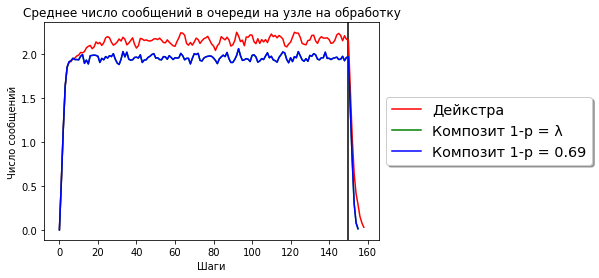

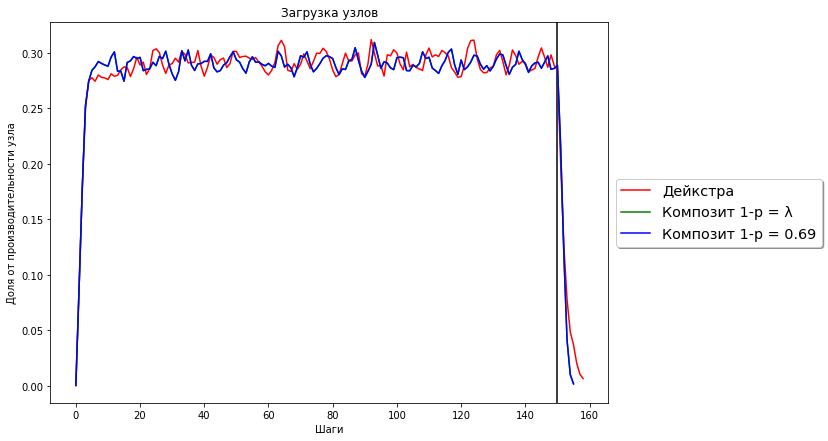

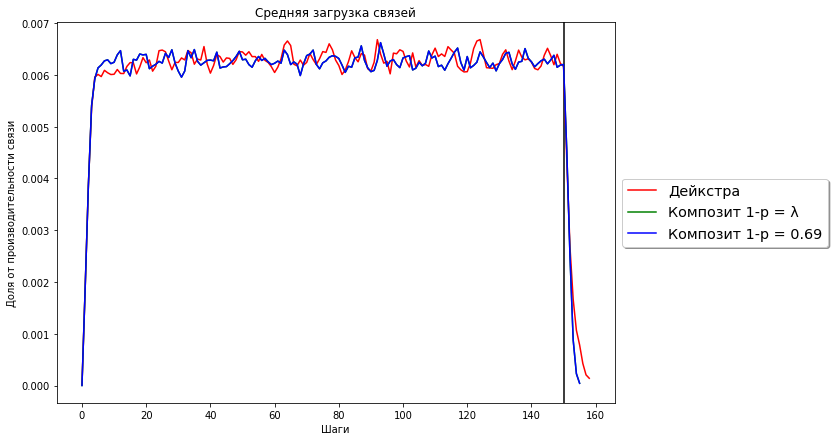

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.69


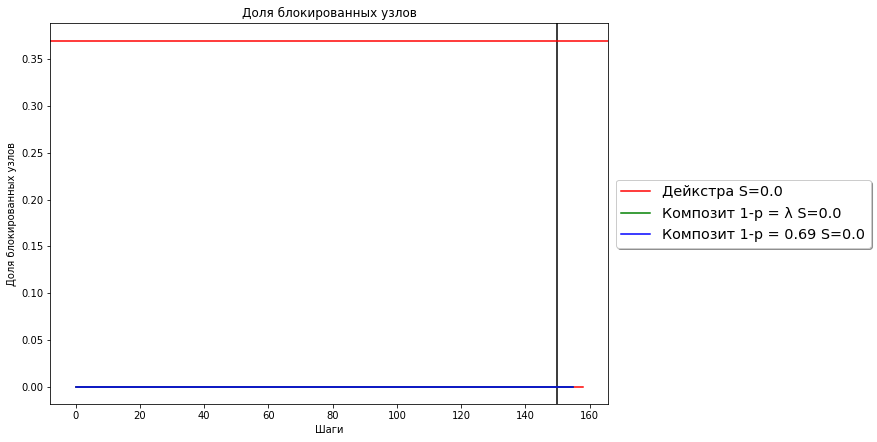

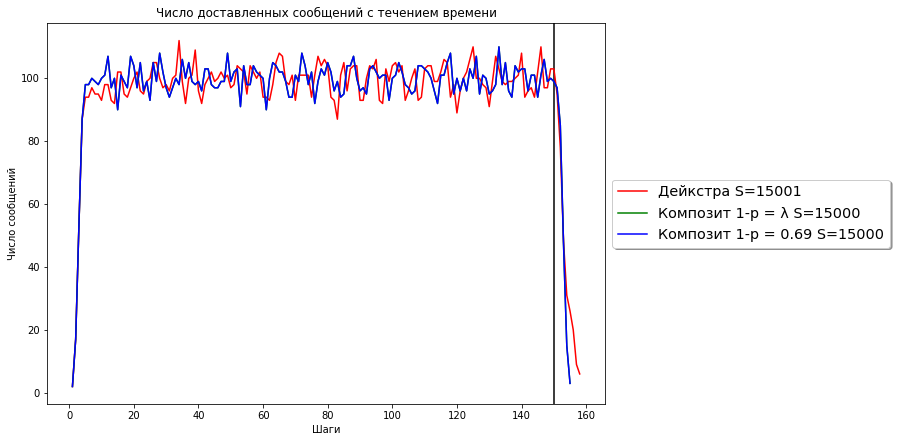

In [2]:
log_tags = [
 {"tag":  "274042ad-81a0-4055-b438-c860e076a475", "label": "Дейкстра", "color": "red"},
 #{"tag":  "29da792a-26fe-4083-ae51-b99a4d501e24", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "f46ba5db-2bb0-4a0a-9c23-b191eb833fa5", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "d58fe7f3-d531-4531-b421-3f5ab09840d7", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

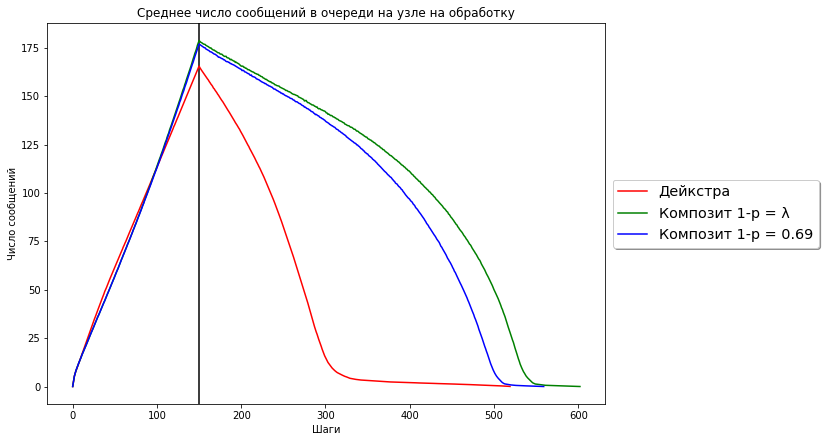

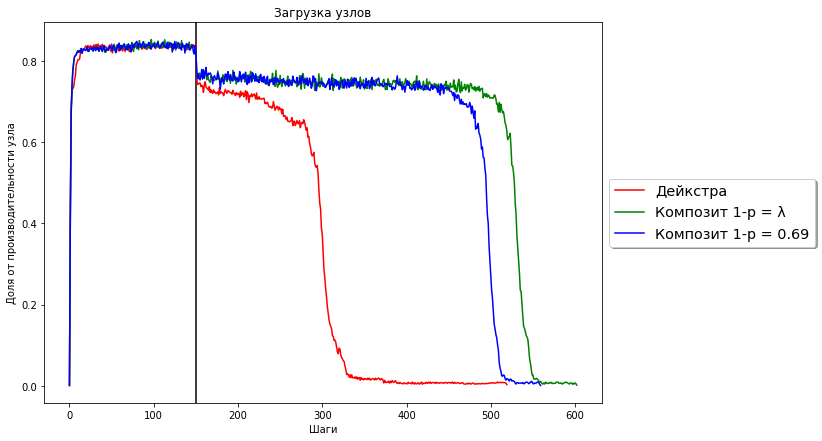

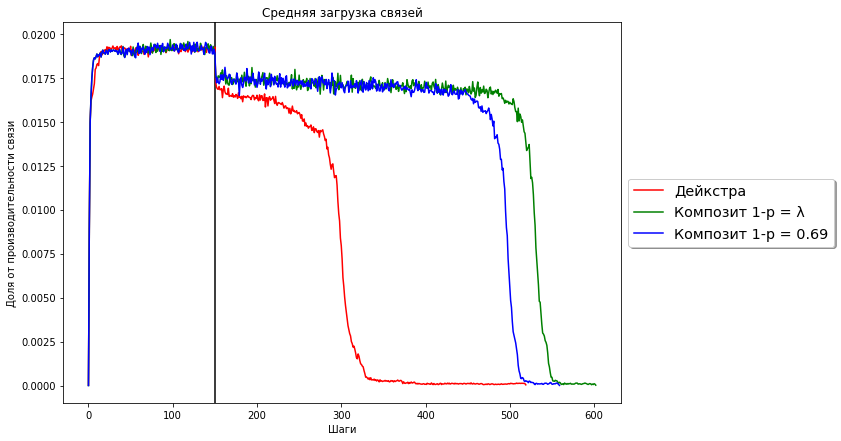

Доставлено 75001 Потеряно 0.0000% -Дейкстра
Доставлено 75000 Потеряно 0.0013% -Композит 1-p = λ
Доставлено 75000 Потеряно 0.0013% -Композит 1-p = 0.69


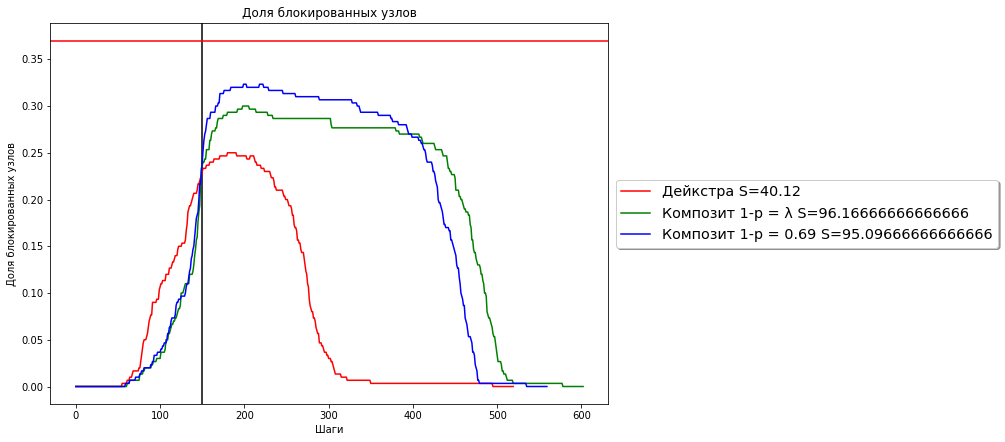

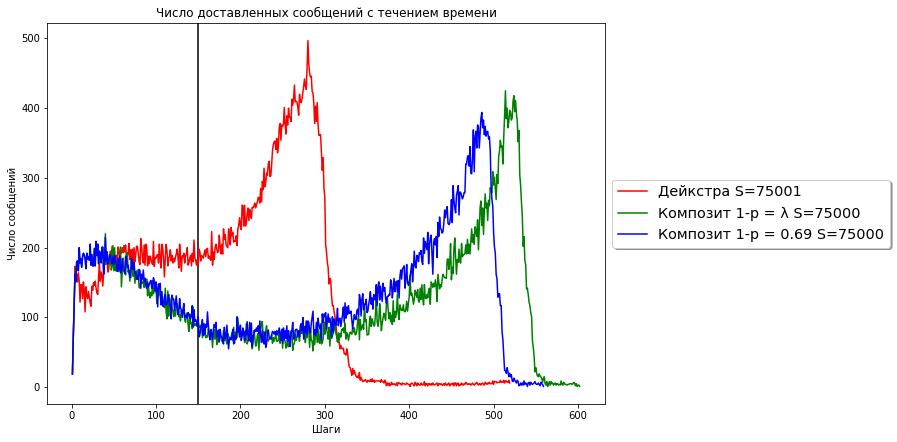

In [3]:
log_tags = [
 {"tag":  "fb689a29-8676-49ba-b503-15fa110a39cb", "label": "Дейкстра", "color": "red"},
 #{"tag":  "6087ed64-cc8b-4c1f-8c53-b8f97d107296", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "a51b94e0-2a97-4323-95a4-9f22f44fe92b", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "d3102479-6cda-4524-adbd-95ad9ed40e9b", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

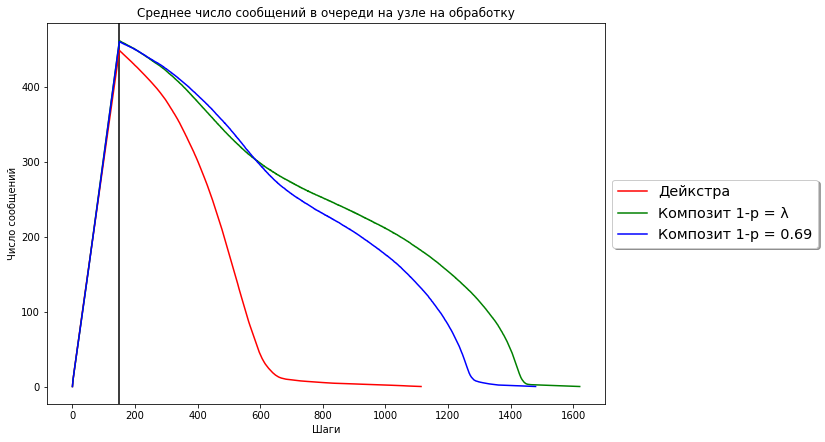

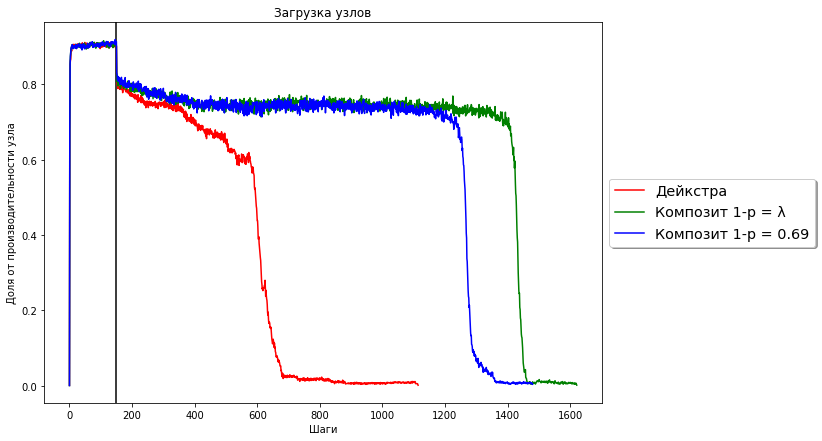

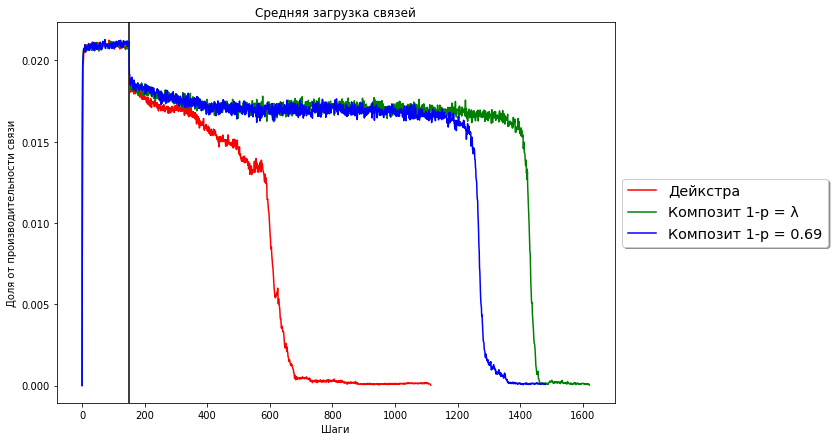

Доставлено 150001 Потеряно 0.0000% -Дейкстра
Доставлено 150000 Потеряно 0.0007% -Композит 1-p = λ
Доставлено 150000 Потеряно 0.0007% -Композит 1-p = 0.69


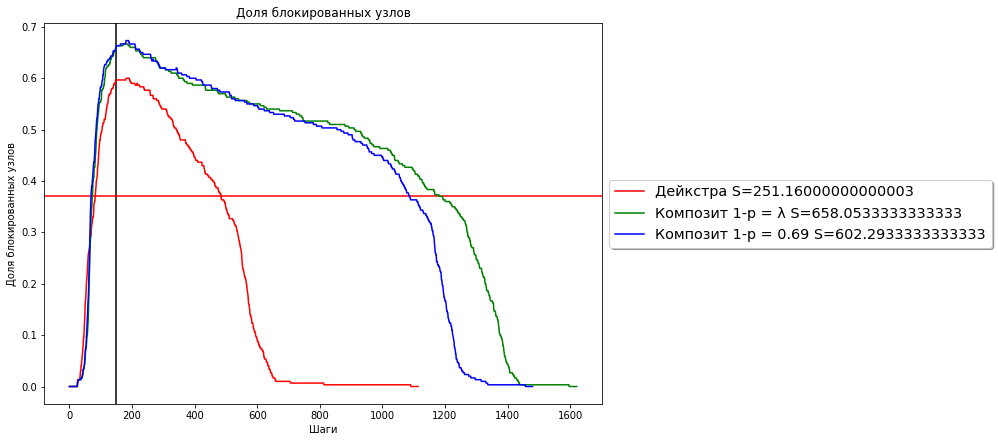

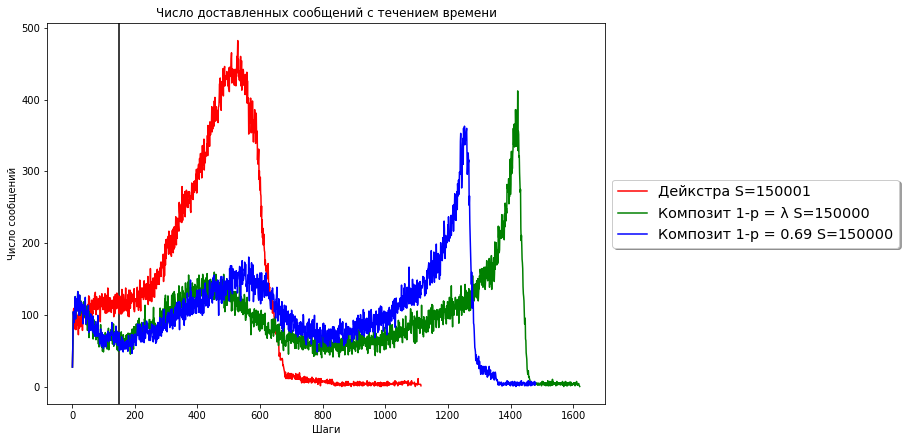

In [4]:
log_tags = [
 {"tag":  "414b0241-e1e9-4e46-9abb-4dde46cd6ea7", "label": "Дейкстра", "color": "red"},
 #{"tag":  "99d4efce-4b69-4f83-bb16-17c3bf44ad26", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "ac90d565-1b45-48c3-b97f-91c98a629d1a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "86efe06b-a055-4577-afa0-fbb6004979b8", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

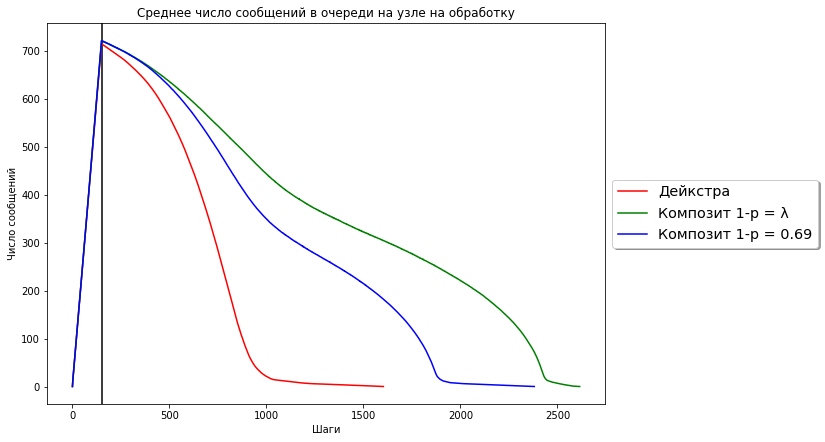

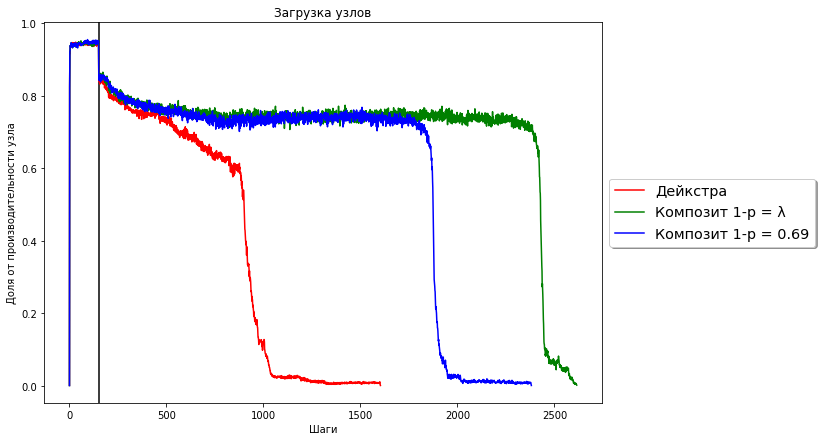

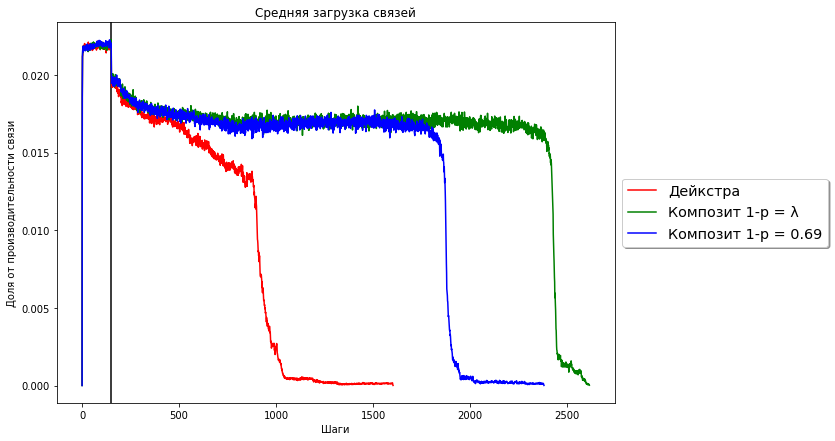

Доставлено 225001 Потеряно 0.0000% -Дейкстра
Доставлено 225000 Потеряно 0.0004% -Композит 1-p = λ
Доставлено 225000 Потеряно 0.0004% -Композит 1-p = 0.69


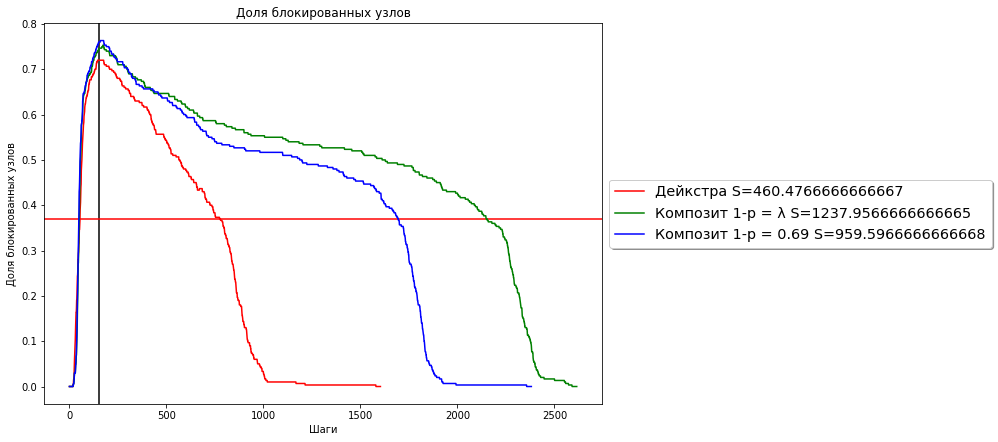

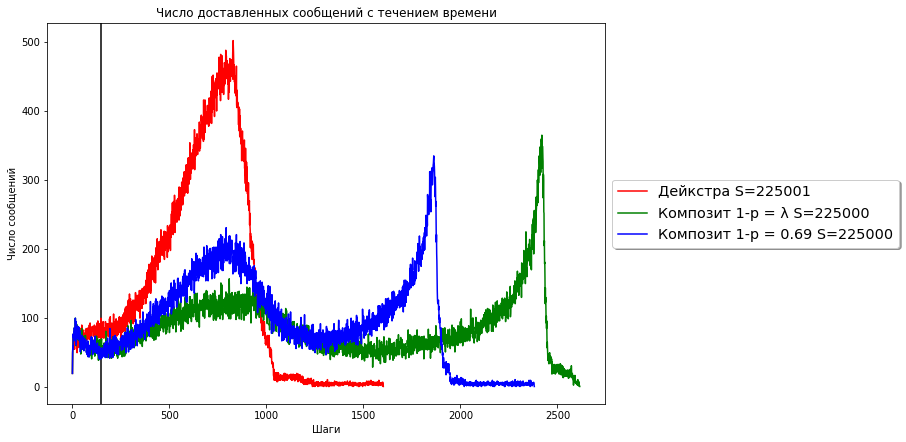

In [5]:
log_tags = [
 {"tag":  "5952af5e-2651-4f7d-997c-322bb28db2f6", "label": "Дейкстра", "color": "red"},
 #{"tag":  "cae1bfe6-7fae-4b04-9460-313128fe6028", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "a1747400-c217-4dfc-b001-58c230efbcd5", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "c3138ec6-8af0-4c65-80ef-e1dbe80e8bfb", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 45001 Потеряно 0.0000% -Дейкстра
Доставлено 45000 Потеряно 0.0022% -Композит 1-p = λ
Доставлено 45000 Потеряно 0.0022% -Композит 1-p = 0.69


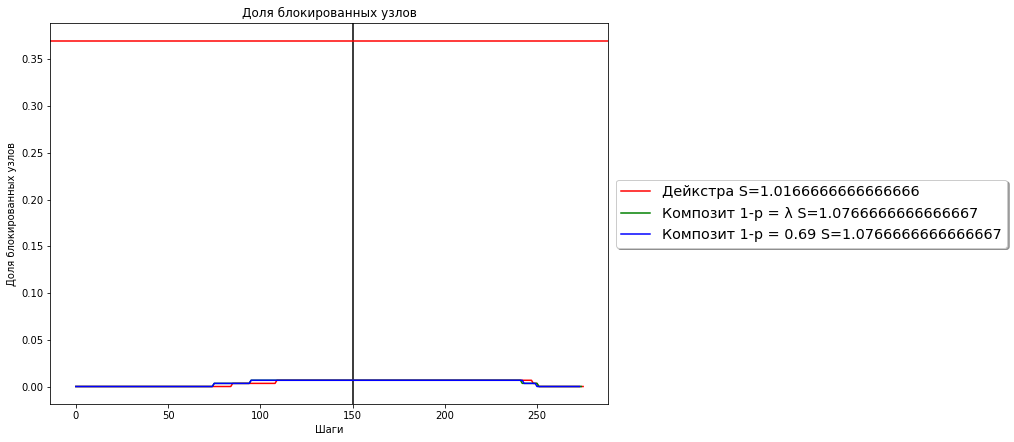

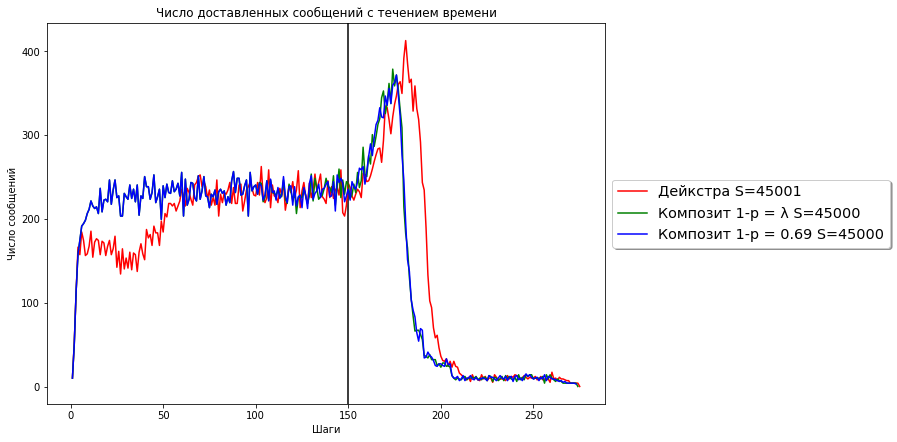

Доставлено 105001 Потеряно 0.0000% -Дейкстра
Доставлено 105000 Потеряно 0.0010% -Композит 1-p = λ
Доставлено 105000 Потеряно 0.0010% -Композит 1-p = 0.69


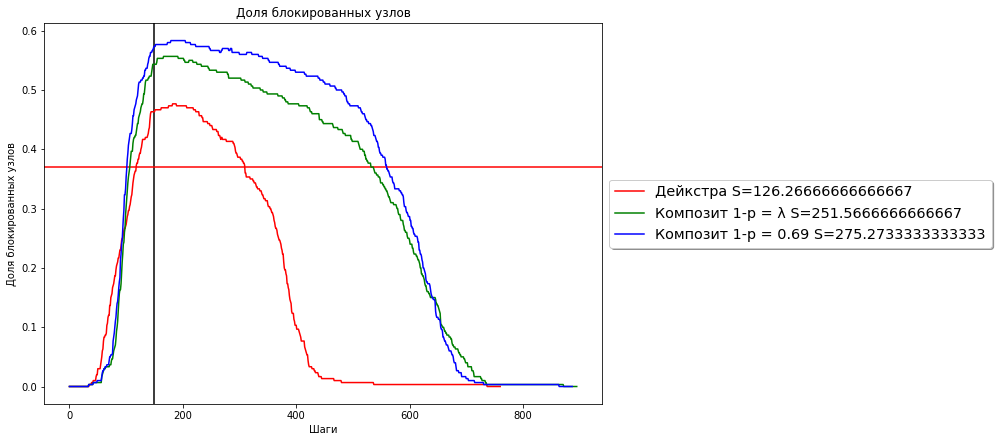

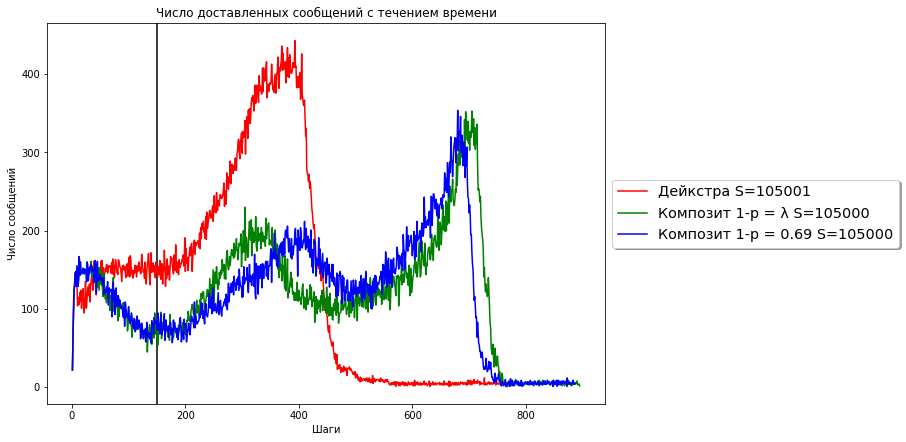

Доставлено 135001 Потеряно 0.0000% -Дейкстра
Доставлено 135000 Потеряно 0.0007% -Композит 1-p = λ
Доставлено 135000 Потеряно 0.0007% -Композит 1-p = 0.69


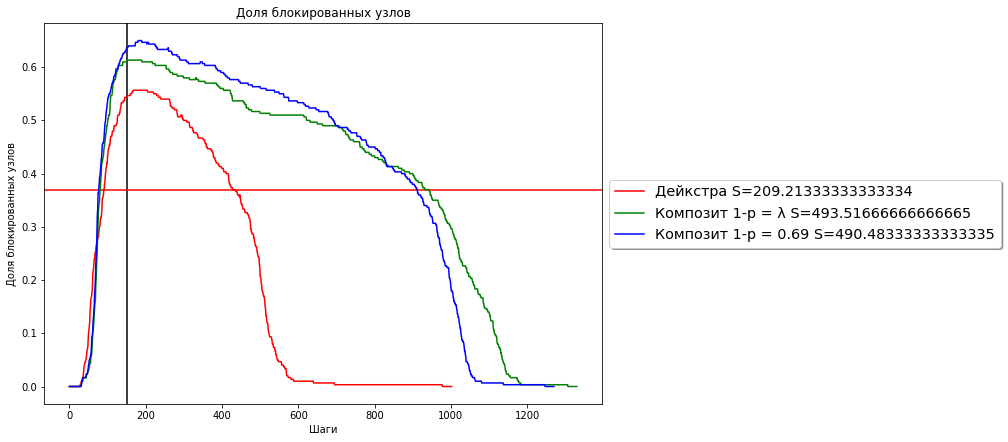

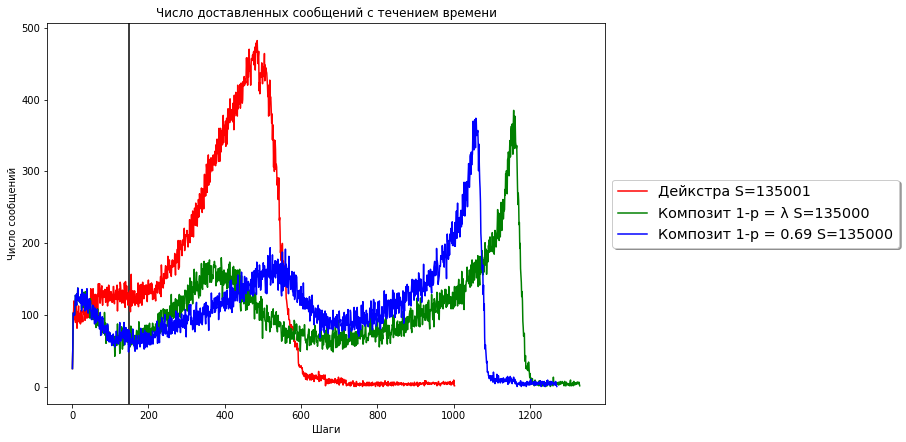

Доставлено 195001 Потеряно 0.0000% -Дейкстра
Доставлено 195000 Потеряно 0.0005% -Композит 1-p = λ
Доставлено 195000 Потеряно 0.0005% -Композит 1-p = 0.69


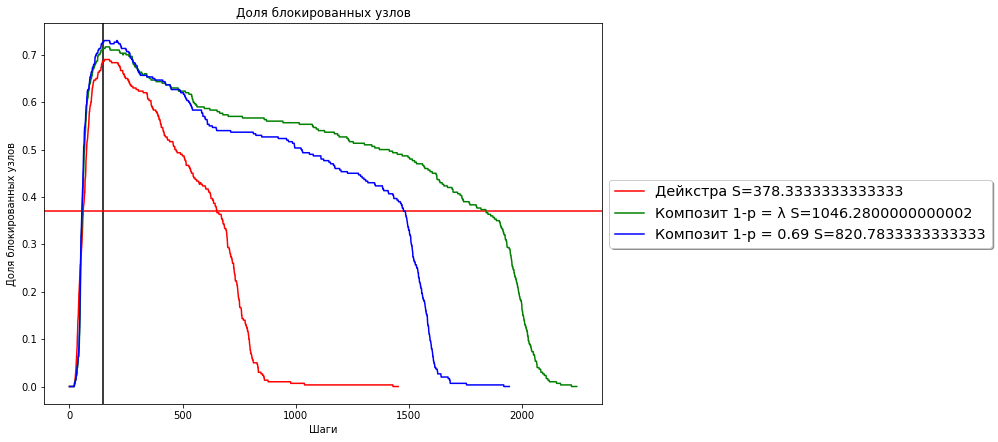

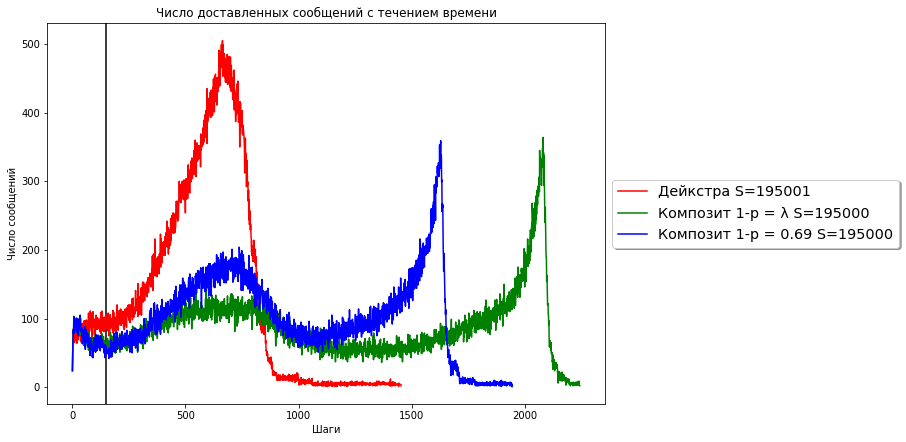

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "78df0973-bfc7-4925-8212-97fb09b70fc0", "label": "Дейкстра", "color": "red"},
 {"tag":  "fd7b6548-15f4-4d25-9117-a5a42e33b611", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "051aabe8-2e81-4da4-9ce3-57e70b22b462", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "1fbe720d-b21c-4999-a698-7408f78be7f5", "label": "Дейкстра", "color": "red"},
 {"tag":  "4d362196-dea0-4d8a-bfbe-6e5a1ac3c670", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "f91121c1-0435-4280-8770-b06851a5764c", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "6d5fab45-773b-4654-a768-14c1bfd4593b", "label": "Дейкстра", "color": "red"},
 {"tag":  "43ecca7d-2117-4854-b9b1-412eb0e0dfee", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "de79194e-cf46-41e5-af6b-ea51a4a08223", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "7d1c0cca-f194-46fe-b47b-877f4c045175", "label": "Дейкстра", "color": "red"},
 {"tag":  "0d257454-f0f4-4805-a264-6adbfb85461c", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b52f7914-6caa-4653-971c-7ebc0dac4e02", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

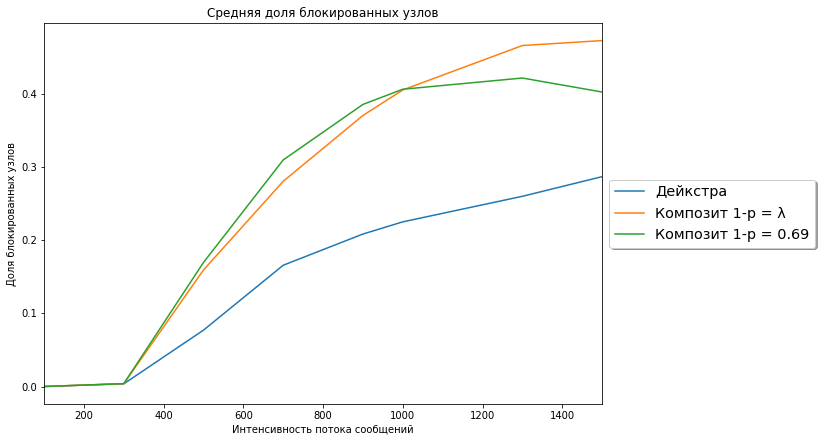

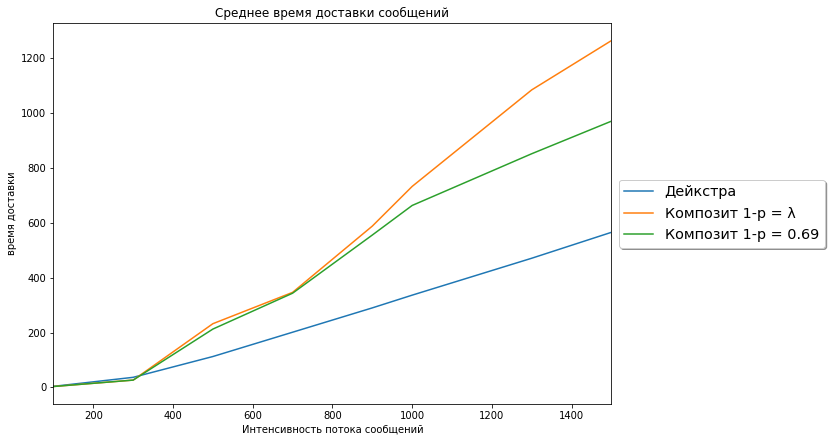

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.153486
Композит 1-p = λ       0.270043
Композит 1-p = 0.69    0.262646

Дейкстра               0.000000
Композит 1-p = λ       0.001692
Композит 1-p = 0.69    0.001692

Дейкстра               252.441449
Композит 1-p = λ       535.263859
Композит 1-p = 0.69    453.840658
